# 一、数据说明

- MNIST数据集是从NIST的Special Database 3（SD-3）和Special Database 1（SD-1）构建而来。Yann LeCun等人从SD-1和SD-3中各取一半数据作为MNIST训练集和测试集，其中训练集来自250位不同的标注员，且训练集和测试集的标注员完全不同。

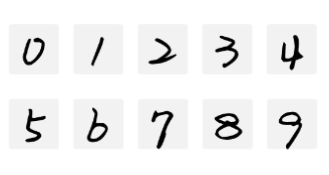

# 2、数据读取

In [1]:
# 加载相关库
import os
import random
import paddle
import numpy as np
from PIL import Image
import gzip
import json

# 定义数据集读取器
def load_data(mode='train'):

    # 读取数据文件
    datafile = './work/mnist.json.gz'
    print('loading mnist dataset from {} ......'.format(datafile))
    data = json.load(gzip.open(datafile))
    # 读取数据集中的训练集，验证集和测试集
    train_set, val_set, eval_set = data

    # 数据集相关参数，图片高度IMG_ROWS, 图片宽度IMG_COLS
    IMG_ROWS = 28
    IMG_COLS = 28
    # 根据输入mode参数决定使用训练集，验证集还是测试
    if mode == 'train':
        imgs = train_set[0]
        labels = train_set[1]
    elif mode == 'valid':
        imgs = val_set[0]
        labels = val_set[1]
    elif mode == 'eval':
        imgs = eval_set[0]
        labels = eval_set[1]
    # 获得所有图像的数量
    imgs_length = len(imgs)
    # 验证图像数量和标签数量是否一致
    assert len(imgs) == len(labels), \
          "length of train_imgs({}) should be the same as train_labels({})".format(
                  len(imgs), len(labels))

    index_list = list(range(imgs_length))

    # 读入数据时用到的batchsize
    BATCHSIZE = 100

    # 定义数据生成器
    def data_generator():
        # 训练模式下，打乱训练数据
        if mode == 'train':
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        # 按照索引读取数据
        for i in index_list:
            # 读取图像和标签，转换其尺寸和类型
            img = np.reshape(imgs[i], [1, IMG_ROWS, IMG_COLS]).astype('float32')
            label = np.reshape(labels[i], [1]).astype('int64')
            imgs_list.append(img) 
            labels_list.append(label)
            # 如果当前数据缓存达到了batch size，就返回一个批次数据
            if len(imgs_list) == BATCHSIZE:
                yield np.array(imgs_list), np.array(labels_list)
                # 清空数据缓存列表
                imgs_list = []
                labels_list = []

        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)

    return data_generator


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):


# 3、多层神经网络

In [2]:
# 定义模型结构
import paddle.nn.functional as F
from paddle.nn import Conv2D, MaxPool2D, Linear# 定义模型结构

In [ ]:
# 多层卷积神经网络实现
class MNIST(paddle.nn.Layer):
     def __init__(self):
         super(MNIST, self).__init__()
         
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
         # 定义一层全连接层，输出维度是10
         self.fc = Linear(in_features=980, out_features=10)
         
   # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
   # 卷积层激活函数使用Relu，全连接层激活函数使用softmax
     def forward(self, inputs, label):
         x = self.conv1(inputs)
         x = F.sigmoid(x)
         x = self.max_pool1(x)
         x = self.conv2(x)
         x = F.sigmoid(x)
         x = self.max_pool2(x)
         x = paddle.reshape(x, [x.shape[0], 980])
         x = self.fc(x)
         x = F.softmax(x)
         if label is not None:
             acc = paddle.metric.accuracy(input=x, label=label)
             return x, acc
         else:
             return x

#调用加载数据的函数
train_loader = load_data('train')
    
#在使用GPU机器时，可以将use_gpu变量设置成True
use_gpu = True
paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

#仅优化算法的设置有所差别
def train(model):
    model = MNIST()
    model.train()
    
    #四种优化算法的设置方案，可以逐一尝试效果
    # opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    # opt = paddle.optimizer.Momentum(learning_rate=0.01, momentum=0.9, parameters=model.parameters())
    # opt = paddle.optimizer.Adagrad(learning_rate=0.01, parameters=model.parameters())
    opt = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    
    EPOCH_NUM = 5
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程
            predicts, acc = model(images, labels)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), acc.numpy()))
                
            #后向传播，更新参数，消除梯度的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    
#创建模型    
model = MNIST()
#启动训练过程
train(model)

loading mnist dataset from ./work/mnist.json.gz ......
epoch: 0, batch: 0, loss is: [2.303979], acc is [0.13]
epoch: 0, batch: 200, loss is: [1.8414118], acc is [0.63]
epoch: 0, batch: 400, loss is: [1.65593], acc is [0.83]
epoch: 1, batch: 0, loss is: [1.5728775], acc is [0.92]
epoch: 1, batch: 200, loss is: [1.5556235], acc is [0.92]
epoch: 1, batch: 400, loss is: [1.5407073], acc is [0.94]
epoch: 2, batch: 0, loss is: [1.537728], acc is [0.93]
epoch: 2, batch: 200, loss is: [1.5053204], acc is [0.97]
epoch: 2, batch: 400, loss is: [1.5163335], acc is [0.96]
epoch: 3, batch: 0, loss is: [1.5102416], acc is [0.96]
epoch: 3, batch: 200, loss is: [1.4986377], acc is [0.97]
epoch: 3, batch: 400, loss is: [1.4801989], acc is [0.99]
epoch: 4, batch: 0, loss is: [1.501479], acc is [0.96]
epoch: 4, batch: 200, loss is: [1.5217798], acc is [0.94]
epoch: 4, batch: 400, loss is: [1.5094486], acc is [0.96]


# 4、RESNET

In [3]:
import paddle.nn as nn

In [4]:
def conv3x3(in_planes,out_planes,stride=1):
    return nn.Conv2D(in_planes,out_planes,kernel_size=3,stride=stride,padding=1)#, bias=False)

In [5]:
class BasicBlock(nn.Layer):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2D(planes)
        self.relu = nn.ReLU()#inplace=True 
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2D(planes)
        self.downsample = downsample
        self.stride = stride  
 
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out

In [6]:
# 残差模块
class Bottleneck(nn.Layer):
    expansion = 4
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2D(inplanes, planes, kernel_size=1)
        self.bn1 = nn.BatchNorm2D(planes)
        self.conv2 = nn.Conv2D(planes, planes, kernel_size=3, stride=stride,padding=1)
        self.bn2 = nn.BatchNorm2D(planes)
        self.conv3 = nn.Conv2D(planes, planes * self.expansion, kernel_size=1)
        self.bn3 = nn.BatchNorm2D(planes * self.expansion)
        self.relu = nn.ReLU()
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
 
        out = self.conv3(out)
        out = self.bn3(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out

In [10]:
# 网络主体
class ResNet(nn.Layer):

    def __init__(self, block, layers, num_classes=1000):
        super(ResNet,self).__init__()
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2D(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2D(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2D(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2D(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
 
        # for m in self.sublayers():
        #     if isinstance(m, nn.Conv2D):
        #         # nn.initializer.KaimingNormal(m.weight, mode='fan_out', nonlinearity='relu')
        #         nn.initializer.KaimingNormal()
        #     elif isinstance(m, nn.BatchNorm2D):
        #         # nn.initializer.constant(m.weight, 1)
        #         nn.initializer.constant()
 
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2D(self.inplanes, planes * block.expansion,kernel_size=1, stride=stride),
                nn.BatchNorm2D(planes * block.expansion),
            )
 
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
 
        return nn.Sequential(*layers)
 
    def forward(self, x,label):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
 
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        if label is not None:
            acc = paddle.metric.accuracy(input=x, label=label)
            return x, acc
        else:
            return x

In [36]:
# model = ResNet(BasicBlock, [2, 2, 2, 2])
# for m in model.sublayers():
#     print(m)

In [45]:
def resnet18(pretrained=False):
    model = ResNet(BasicBlock, [2, 2, 2, 2])
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model

In [8]:
#调用加载数据的函数
train_loader = load_data('train')
    
#在使用GPU机器时，可以将use_gpu变量设置成True
use_gpu = True
paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

loading mnist dataset from ./work/mnist.json.gz ......


CUDAPlace(0)

In [ ]:
#仅优化算法的设置有所差别
def train(model):
    model = ResNet()
    model.train()
    
    #四种优化算法的设置方案，可以逐一尝试效果
    # opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    # opt = paddle.optimizer.Momentum(learning_rate=0.01, momentum=0.9, parameters=model.parameters())
    # opt = paddle.optimizer.Adagrad(learning_rate=0.01, parameters=model.parameters())
    opt = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    
    EPOCH_NUM = 5
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程
            predicts, acc = model(images, labels)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), acc.numpy()))
                
            #后向传播，更新参数，消除梯度的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'resnet18.pdparams')
    
#创建模型    
model = ResNet()
#启动训练过程
train(model)

In [ ]:
def evaluation(model):
    print('start evaluation .......')
    # 定义预测过程
    params_file_path = 'mnist.pdparams'
    # 加载模型参数
    param_dict = paddle.load(params_file_path)
    model.load_dict(param_dict)

    model.eval()
    eval_loader = load_data('eval')

    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(eval_loader()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        predicts, acc = model(images, labels)
        loss = F.cross_entropy(input=predicts, label=labels)
        avg_loss = paddle.mean(loss)
        acc_set.append(float(acc.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))
    
    #计算多个batch的平均损失和准确率
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()

    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

model = MNIST()
evaluation(model)

start evaluation .......
loading mnist dataset from ./work/mnist.json.gz ......
loss=1.4917580950260163, acc=0.9753000062704086


# 5、加入正则化项
   
## 5、1 过拟合

对于样本量有限、但需要使用强大模型的复杂任务，模型很容易出现过拟合的表现，即在训练集上的损失小，在验证集或测试集上的损失较大，如 **图2** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/99b879c21113494a9d7315eeda74bc4c8fea07f984824a03bf8411e946c75f1b" width="400" hegiht="" ></center>
<center><br>图2：过拟合现象，训练误差不断降低，但测试误差先降后增</br></center>
<br></br>

反之，如果模型在训练集和测试集上均损失较大，则称为欠拟合。过拟合表示模型过于敏感，学习到了训练数据中的一些误差，而这些误差并不是真实的泛化规律（可推广到测试集上的规律）。欠拟合表示模型还不够强大，还没有很好的拟合已知的训练样本，更别提测试样本了。因为欠拟合情况容易观察和解决，只要训练loss不够好，就不断使用更强大的模型即可，因此实际中我们更需要处理好过拟合的问题。

## 5、2 导致过拟合原因

造成过拟合的原因是模型过于敏感，而训练数据量太少或其中的噪音太多。

如**图3** 所示，理想的回归模型是一条坡度较缓的抛物线，欠拟合的模型只拟合出一条直线，显然没有捕捉到真实的规律，但过拟合的模型拟合出存在很多拐点的抛物线，显然是过于敏感，也没有正确表达真实规律。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/53c389bb3c824706bd2fbc05f83ab0c6dd6b5b2fdedb4150a17e16a1b64c243e" width="700" hegiht="" ></center>
<center><br>图3：回归模型的过拟合，理想和欠拟合状态的表现</br></center>
<br></br>

如**图4** 所示，理想的分类模型是一条半圆形的曲线，欠拟合用直线作为分类边界，显然没有捕捉到真实的边界，但过拟合的模型拟合出很扭曲的分类边界，虽然对所有的训练数据正确分类，但对一些较为个例的样本所做出的妥协，高概率不是真实的规律。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/b5a46f7e0fbe4f8686a71d9a2d330ed09f23bca565a44e0d941148729fd2f7d7" width="700" hegiht="" ></center>
<center><br>图4：分类模型的欠拟合，理想和过拟合状态的表现</br></center>
<br></br>


# 6、训练

In [ ]:
def train(model):
    model.train() 

    #各种优化算法均可以加入正则化项，避免过拟合，参数regularization_coeff调节正则化项的权重
    # opt = paddle.optimizer.SGD(learning_rate=0.01, weight_decay=paddle.regularizer.L2Decay(coeff=0.1), parameters=model.parameters())
    opt = paddle.optimizer.Adam(learning_rate=0.001, weight_decay=paddle.regularizer.L2Decay(coeff=1e-5), parameters=model.parameters())           

    EPOCH_NUM = 5
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据，变得更加简洁
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程，同时拿到模型输出值和分类准确率
            predicts, acc = model(images, labels)
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), acc.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist_regul.pdparams')

model = MNIST()
train(model)

epoch: 0, batch: 0, loss is: [2.3026774], acc is [0.09]
epoch: 0, batch: 200, loss is: [2.087901], acc is [0.37]


In [ ]:
def evaluation(model):
    print('start evaluation .......')
    # 定义预测过程
    params_file_path = 'mnist_regul.pdparams'
    # 加载模型参数
    param_dict = paddle.load(params_file_path)
    model.load_dict(param_dict)

    model.eval()
    eval_loader = load_data('eval')

    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(eval_loader()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        predicts, acc = model(images, labels)
        loss = F.cross_entropy(input=predicts, label=labels)
        avg_loss = paddle.mean(loss)
        acc_set.append(float(acc.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))
    
    #计算多个batch的平均损失和准确率
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()

    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

model = MNIST()
evaluation(model)

start evaluation .......
loading mnist dataset from ./work/mnist.json.gz ......
loss=1.4930677473545075, acc=0.9744000065326691


# 7、可视化

In [ ]:
#引入matplotlib库
import matplotlib.pyplot as plt

def train(model):
    model.train()
    
    opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    
    EPOCH_NUM = 10
    iter=0
    iters=[]
    losses=[]
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据，变得更加简洁
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程，同时拿到模型输出值和分类准确率
            predicts, acc = model(images, labels)
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 100 == 0:
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), acc.numpy()))
                iters.append(iter)
                losses.append(avg_loss.numpy())
                iter = iter + 100
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
            
    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    
    return iters, losses
    
model = MNIST()
iters, losses = train(model)

epoch: 0, batch: 0, loss is: [2.3012097], acc is [0.09]
epoch: 0, batch: 100, loss is: [2.2782855], acc is [0.13]
epoch: 0, batch: 200, loss is: [2.1648223], acc is [0.39]
epoch: 0, batch: 300, loss is: [1.9878807], acc is [0.63]
epoch: 0, batch: 400, loss is: [1.9145163], acc is [0.63]
epoch: 1, batch: 0, loss is: [1.8571677], acc is [0.63]
epoch: 1, batch: 100, loss is: [1.750027], acc is [0.73]
epoch: 1, batch: 200, loss is: [1.8604438], acc is [0.65]
epoch: 1, batch: 300, loss is: [1.8288481], acc is [0.64]
epoch: 1, batch: 400, loss is: [1.9056515], acc is [0.59]
epoch: 2, batch: 0, loss is: [1.7847908], acc is [0.69]
epoch: 2, batch: 100, loss is: [1.7898918], acc is [0.68]
epoch: 2, batch: 200, loss is: [1.7043725], acc is [0.79]
epoch: 2, batch: 300, loss is: [1.7687974], acc is [0.72]
epoch: 2, batch: 400, loss is: [1.8072536], acc is [0.67]
epoch: 3, batch: 0, loss is: [1.7414157], acc is [0.74]
epoch: 3, batch: 100, loss is: [1.7308689], acc is [0.74]
epoch: 3, batch: 200, l

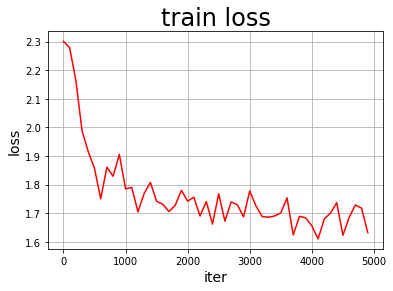

In [ ]:
#画出训练过程中Loss的变化曲线
plt.figure()
plt.title("train loss", fontsize=24)
plt.xlabel("iter", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.plot(iters, losses,color='red',label='train loss') 
plt.grid()
plt.show()